## Import required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy as scipy
from scipy.spatial import KDTree
import json
# graph representation
import networkx as nx
# GNU linear programming kit (to use GLPK)
import pulp
# Pulser imports
from pulser import Pulse, Sequence, Register
from pulser.devices import MockDevice
from pulser.waveforms import BlackmanWaveform, RampWaveform, ConstantWaveform, InterpolatedWaveform
from pulser_simulation import SimConfig, QutipEmulator

## Define Problem Data

### retrieved popuplation

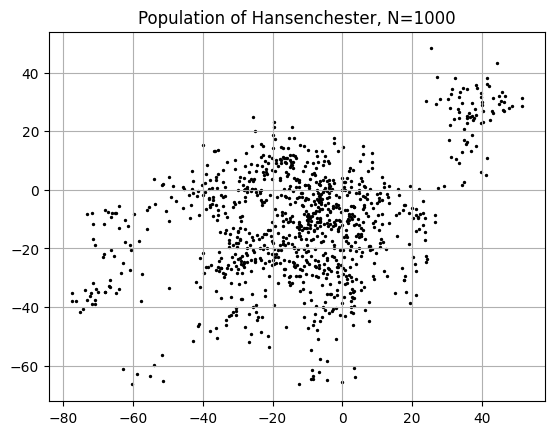

In [2]:
cities = ["Bradleymouth", "Brandonberg", "Hansenchester", "Joshuachester", "New Rebeccaberg", "North Carl", "North Christopherbury", "Port Jonathan", "Zacharyburgh", 'North Joshua']
city_name = cities[2]

with open('./data/population_{}.json'.format(city_name), 'r') as json_file:
    data = json.load(json_file)

params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])
plt.scatter(x, y, s=2, facecolor='black')
plt.title('Population of {}, N={}'.format(city_name, len(x)))
plt.grid(True)

### Coverage function to maximize

Optimization Function $COV$ for $N$ antennas is given by:

$$
COV = \sum_{i \in N} d_R(i) - B \sum_{i,j \in A} \text{Interfere}(i, j)
$$

where:

$$
\text{Interfere}(i, j) = \begin{cases} 
1, & \text{if } ||\vec{r}_i - \vec{r}_j|| < 2R \\
0, & \text{otherwise}
\end{cases}
$$

with
- coverage radius $R$ = 25
- antenna position $\vec{r}_i$
- $d_R(i)$ the nb. of population points within radius R around $\vec{r}_i$
- interference for $d < 2R$
- maximum nb. of antennas = 70
- minimum coverage = 0.7 $\times$ #population


In [3]:
def evaluate_coverage(data, placement, R_dist):
    x = np.array(data['x'])
    y = np.array(data['y'])
    B = len(x)
    coords = np.array([[x[i], y[i]] for i in range(len(x))])
    cost = 0
    for i in range(len(placement)):
        coord_i = np.array([placement[i]])
        for j in range(len(placement)):
            coord_j = np.array([placement[j]])
            if i != j:
                dist = scipy.spatial.distance.cdist(coord_i, coord_j)
                if dist < (2 + 1e-3)*R_dist:
                    cost += -B


        dist = scipy.spatial.distance.cdist(coord_i, coords)
        cov = np.sum(dist < R_dist)
        cost += cov

    if cost < 0:
        return -np.inf
    else:
        return cost

### Generate the grid

In [4]:
def generate_triangular_grid(side_lengths, spacing, offset):
    rows, cols = side_lengths
    points = []
    for row in range(rows):
        for col in range(cols):
            # Calculate the x coordinate
            x = col * spacing
            # Offset every other row by half the side length
            if row % 2 == 1:
                x += spacing / 2
            # Calculate the y coordinate based on the row number
            y = row * (spacing * (3**0.5) / 2)  # Height of an equilateral triangle
            points.append([x + offset[0], y + offset[1]])
    return points 

### Define the problem parameters

In [5]:
# Problem Parameters
population_x = x # x coordinates of the population
population_y = y # y coordinates of the population
R_antennas = 25  # Operating radius for each antenna
max_antennas = 70  # Maximum number of antennas
minimum_coverage = 0.7 * len(population_x) # Minimum coverage of the population required
# Grid Parameters
spacing = 1.2*R_antennas  # Spacing between antennas
offset = (population_x.min(), population_y.min())  # Offset for the grid
side_lengths = (int(np.ceil((population_x.max() - population_x.min())/spacing)), int(np.ceil((population_y.max() - population_y.min())/spacing)))  # Number of antennas in each direction
grid_points = generate_triangular_grid(side_lengths=side_lengths, spacing=spacing, offset=offset)  # Generate the grid points


Calculate the coverage at each point of the grid

In [6]:
z_coverage = np.zeros(len(grid_points))
coords = np.array([[population_x[i], population_y[i]] for i in range(len(x))])
for i in range(len(grid_points)):
    # val_y = y_test[i,j]
    start = np.array(grid_points[i])
    # print(start)
    dist = scipy.spatial.distance.cdist(np.array([start]), coords)
    truth_table = (dist <= R_antennas)
    cov = np.sum(truth_table)
    z_coverage[i] = cov

Plot the coverage map

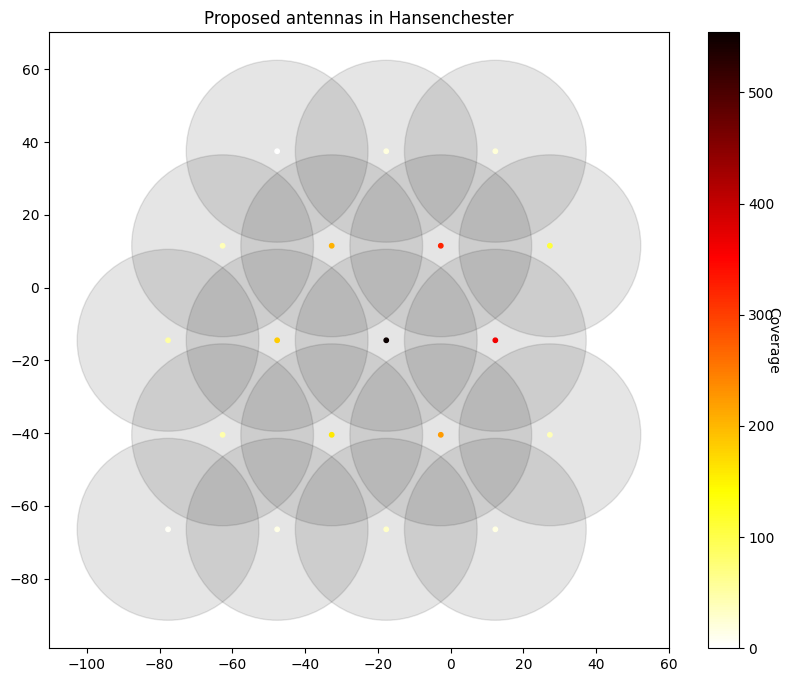

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plt.title('Proposed antennas in {}'.format(city_name))
ind = 0
for (xi, yi) in zip(np.array(grid_points)[:,0], np.array(grid_points)[:,1]):
    if z_coverage[ind] > 1e-3:
        circle = patches.Circle((xi, yi), R_antennas, edgecolor='black', facecolor='black', transform=ax.transData, alpha = 0.1)
        ax.add_patch(circle)
    ind += 1
scatter = ax.scatter(np.array(grid_points)[:,0], np.array(grid_points)[:,1], s=10, c = z_coverage, cmap = 'hot_r')

cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Coverage', rotation=270)

Build the graph with grid points

{4: Text(-62.68360424927863, -40.46828734697149, '4'),
 9: Text(-47.68360424927863, -14.48752523343834, '9'),
 12: Text(-62.68360424927863, 11.493236880094813, '12'),
 16: Text(-77.68360424927863, 37.47399899362797, '16'),
 3: Text(12.31639575072137, -66.44904946050465, '3'),
 7: Text(27.31639575072137, -40.46828734697149, '7'),
 13: Text(-32.68360424927863, 11.493236880094813, '13'),
 5: Text(-32.68360424927863, -40.46828734697149, '5'),
 10: Text(-17.68360424927863, -14.48752523343834, '10'),
 8: Text(-77.68360424927863, -14.48752523343834, '8'),
 14: Text(-2.6836042492786305, 11.493236880094813, '14'),
 19: Text(12.31639575072137, 37.47399899362797, '19'),
 17: Text(-47.68360424927863, 37.47399899362797, '17'),
 18: Text(-17.68360424927863, 37.47399899362797, '18'),
 2: Text(-17.68360424927863, -66.44904946050465, '2'),
 11: Text(12.31639575072137, -14.48752523343834, '11'),
 6: Text(-2.6836042492786305, -40.46828734697149, '6'),
 15: Text(27.31639575072137, 11.493236880094813, '15'

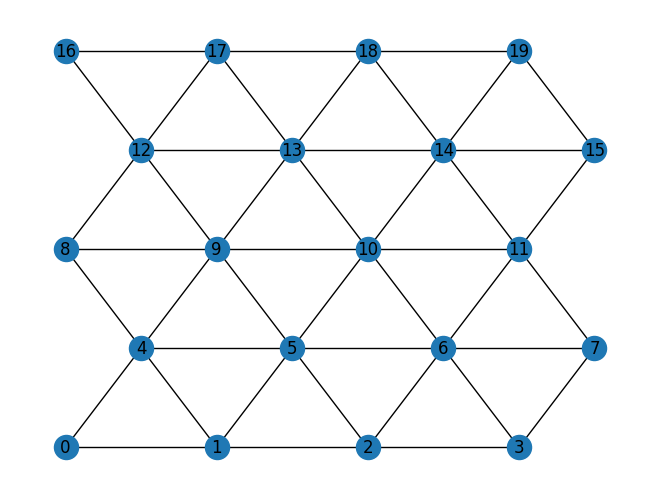

In [8]:
graph = nx.Graph()
edges = KDTree(grid_points).query_pairs(R_antennas * (2 + 1e-3))
graph.add_edges_from(edges)
nx.draw(graph, pos=grid_points)
nx.draw_networkx_labels(graph, pos=grid_points)

### Integer Linear Programming Solver (ILP)

**Objective Function**:

$$
\text{Maximize} \sum_{i} d_R(i) z_i - B \sum_{i < j} y_{ij}
$$

**Subject to**:

1. **Coverage Constraint**:
   - Population point $j$ is considered covered if it is within radius $R$ of any antenna position:
   $$
   c_j \leq \sum_{i : ||\vec{r}_i - \vec{p}_j|| \leq R} z_i \quad \forall j
   $$

2. **Minimum Coverage Requirement**:
   - At least 70% of the total population must be covered:
   $$
   \sum_{j} c_j \geq 0.7 \times \text{total population size}
   $$

3. **Interference Constraint**:
   - Antennas $i$ and $j$ must not interfere if placed closer than $2R$:
   $$
   y_{ij} \geq z_i + z_j - 1 \quad \forall i, j \text{ where } ||\vec{r}_i - \vec{r}_j|| < 2R
   $$

4. **Antenna Count Constraint**:
   - Maximum number of Antenna must not exceed 70:
   $$
   \sum_{i} z_i \leq 70
   $$

5. **Binary Constraints**:
   - The decision variables must be binary:
   $$
   z_i \in \{0, 1\}, \quad c_j \in \{0, 1\}, \quad y_{ij} \in \{0, 1\}
   $$

**Definitions**:
- $z_i$: Binary variable indicating if an antenna is placed at position $\vec{r}_i$.
- $c_j$: Binary variable indicating if population point $j$ is covered.
- $y_{ij}$: Binary variable representing interference between antennas $i$ and $j$.
- $d_R(i)$: Number of population points within radius $R$ of antenna $i$.
- $B$: Penalty constant for interference.


In [9]:
# Set up the ILP problem using PuLP
problem = pulp.LpProblem("Antenna_Placement_Optimization", pulp.LpMaximize)

# Decision variables
z = pulp.LpVariable.dicts("z", range(len(grid_points)), cat='Binary')
c = pulp.LpVariable.dicts("c", range(len(population_x)), cat='Binary')
y = pulp.LpVariable.dicts("y", edges, cat='Binary')

# Objective function
B = len(population_x)  # Penalty for interference
problem += (
    pulp.lpSum(c[j] for j in range(len(population_x))) - 
    B * pulp.lpSum(y[i, j] for i, j in edges),
    "Maximize_Coverage"
)

# Constraints
# Coverage constraint
for j in range(len(population_x)):
    population_coord = np.array([population_x[j], population_y[j]])
    covering_antennas = [
        i for i in range(len(grid_points)) 
        if np.linalg.norm(grid_points[i] - population_coord) <= R_antennas
    ]
    problem += (c[j] <= pulp.lpSum(z[i] for i in covering_antennas), f"Coverage_Constraint_{j}")

# Minimum coverage requirement
problem += (pulp.lpSum(c[j] for j in range(len(population_x))) >= minimum_coverage, "Minimum_Coverage")

# Interference constraints
for i, j in edges:
    problem += (y[i, j] >= z[i] + z[j] - 1, f"Interference_Constraint_{i}_{j}")

# Antenna count constraint
problem += (pulp.lpSum(z[i] for i in range(len(grid_points))) <= 70, "Max_Antennas")

Check installed solver 
(if GLPK is not installed, use PULP_CBC_CMD)

In [13]:
print(pulp.listSolvers(onlyAvailable=True))

['GLPK_CMD', 'PULP_CBC_CMD']


In [14]:
# Solve the problem using GLPK
# solver = pulp.PULP_CBC_CMD()
solver = pulp.GLPK_CMD()
problem.solve(solver)

# Display results
print("Status:", pulp.LpStatus[problem.status])
print("Total Coverage:", pulp.value(problem.objective))

selected_antennas = [i for i in range(len(grid_points)) if z[i].value() == 1]
print("Number of Antennas Placed:", len(selected_antennas))
print("Antenna Positions (selected):", [grid_points[i] for i in selected_antennas])

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --cpxlp /var/folders/2p/l5x_c52n7g7c1nx8x8v82j7c0000gn/T/096a79ad49be47819529a528cfbd1854-pulp.lp
 -o /var/folders/2p/l5x_c52n7g7c1nx8x8v82j7c0000gn/T/096a79ad49be47819529a528cfbd1854-pulp.sol
Reading problem data from '/var/folders/2p/l5x_c52n7g7c1nx8x8v82j7c0000gn/T/096a79ad49be47819529a528cfbd1854-pulp.lp'...
1045 rows, 1063 columns, 4554 non-zeros
1063 integer variables, all of which are binary
2345 lines were read
GLPK Integer Optimizer 5.0
1045 rows, 1063 columns, 4554 non-zeros
1063 integer variables, all of which are binary
Preprocessing...
845 hidden covering inequaliti(es) were detected
1026 rows, 1045 columns, 4498 non-zeros
1045 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 1026
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
10

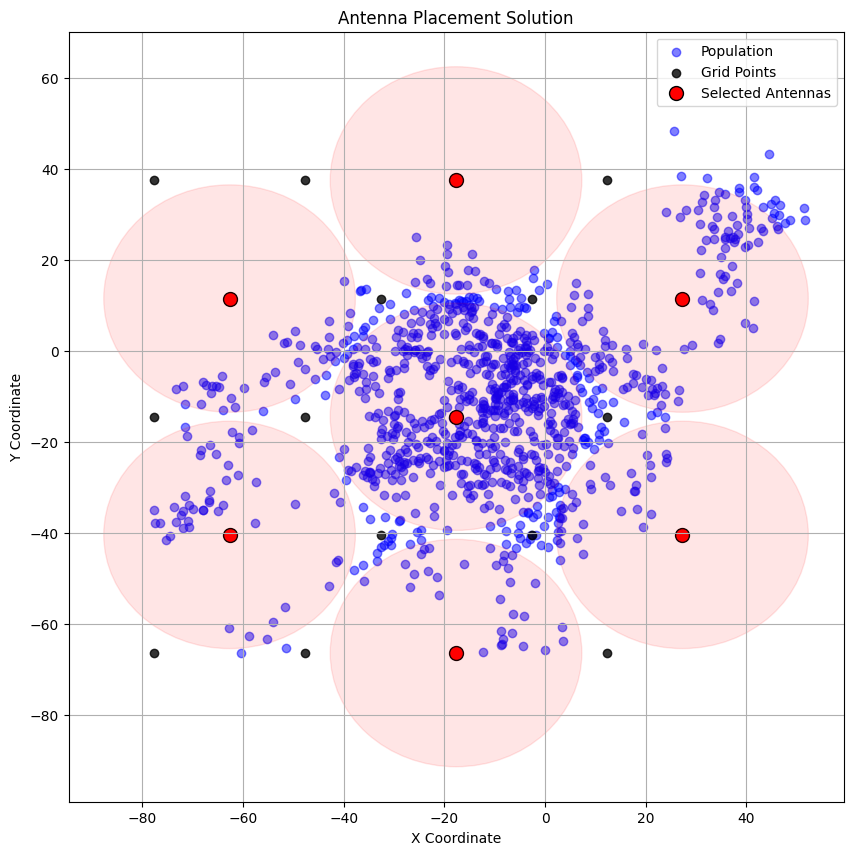

Population coverage: 840 out of 1000
Evaluation coverage: 840


In [15]:
# Plot the solution with selected antennas
plt.figure(figsize=(10, 10))

# Plot population points
plt.scatter(population_x, population_y, c='blue', label='Population', alpha=0.5)

# Plot all candidate grid points
plt.scatter(np.array(grid_points)[:,0], np.array(grid_points)[:, 1], c='black', label='Grid Points', alpha=0.8)

# Highlight the selected antennas
selected_antennas_positions = [grid_points[i] for i in selected_antennas]
selected_antennas_x = [pos[0] for pos in selected_antennas_positions]
selected_antennas_y = [pos[1] for pos in selected_antennas_positions]
plt.scatter(selected_antennas_x, selected_antennas_y, c='red', label='Selected Antennas', s=100, edgecolors='black')

# Plot coverage circles for selected antennas
for pos in selected_antennas_positions:
    circle = plt.Circle((pos[0], pos[1]), R_antennas, color='red', alpha=0.1)
    plt.gca().add_patch(circle)

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Antenna Placement Solution')
plt.legend()
plt.grid(True)
plt.show()

score = evaluate_coverage(data, selected_antennas_positions, R_antennas)
population_coverage = np.sum([c[i].value() for i in range(len(c))])
print(f'Population coverage: {population_coverage} out of {len(population_x)}')
print(f'Evaluation coverage: {score}')